In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre


import warnings
warnings.filterwarnings('ignore')

In [2]:
yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [7]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)

Extract Parameters for: 2002 to 2012


In [8]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, YYS_, YYE_, NY_ = [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'YYS', YYS_)
new_df.insert(4, 'YYE', YYE_)
new_df.insert(5, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

In [9]:
frac = 0.8

Q_80 = clear_df.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = clear_df.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(clear_df)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 200
80% DataFrame: 160
20% DataFrame: 40


In [10]:
# Manual remove for strange station
wa_filter = Q_80[Q_80['Q50']<=600]
# wa_filter = Q_80[Q_80['Q50']<=380]
wa_filter = wa_filter.reset_index(drop=True)

In [11]:
lon_min_rect, lon_max_rect = lon_min, lon_max
lat_min_rect, lat_max_rect = lat_min, lat_max

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [12]:
wa_gdf = gpd.GeoDataFrame(wa_filter, geometry=gpd.points_from_xy(wa_filter['Lon'], wa_filter['Lat']), crs="EPSG:4326")
wa_inside_rect = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect = wa_inside_rect.drop(columns=['index_right'])

QOBS_area_mean = np.nanmean(wa_inside_rect.iloc[:,6:-1].values,axis=0)
QOBS_area_mean

array([132.09156662, 153.75373876, 183.60344632, 207.34006708,
       232.16018842])

In [13]:
def convert_lat_lon_point(lon_in, lat_in):
    lon2d, lat2d = np.meshgrid(lon_in, lat_in)
    points = [Point(lon, lat) for lon, lat in zip(lon2d.ravel(), lat2d.ravel())]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
    points_in_rect = gpd.sjoin(points_gdf, rect_gdf, how="inner", predicate="within")
    
    lon_inside = points_in_rect.geometry.x.values  # Longitudes dentro del rectángulo
    lat_inside = points_in_rect.geometry.y.values  # Latitudes dentro del rectángulo
    
    lon_indices = [np.argmin(np.abs(lon_in - lon)) for lon in lon_inside]
    lat_indices = [np.argmin(np.abs(lat_in - lat)) for lat in lat_inside]
    
    lon_indices = np.unique(lon_indices)
    lat_indices = np.unique(lat_indices)
    
    lon2d, lat2d = np.meshgrid(lon_in[lon_indices],lat_in[lat_indices])
    
    return lon_indices, lat_indices, lon2d, lat2d

Text(0.0, 1.0, 'OBS')

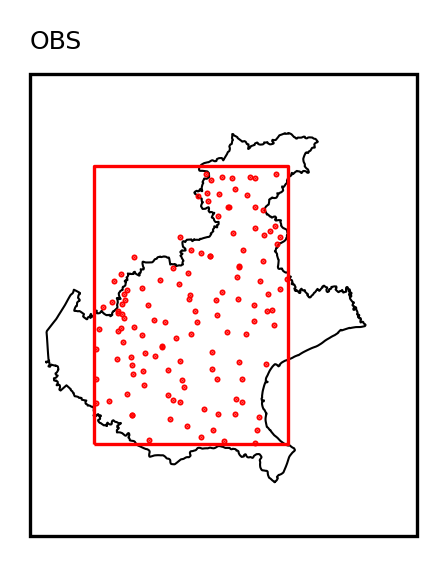

In [14]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
# ax1.scatter(lon_ERA5, lat_ERA5,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(wa_inside_rect['Lon'].values, wa_inside_rect['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')
ax1.set_title('OBS', fontsize=6, loc='left')

In [15]:
frac = 0.8

Q_80 = wa_inside_rect.sample(frac=frac, random_state=42)
Q_20 = wa_inside_rect.loc[~wa_inside_rect.index.isin(Q_80.index)].copy()

Q_80 = Q_80.reset_index(drop=True)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(wa_inside_rect)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 127
80% DataFrame: 102
20% DataFrame: 25


In [16]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [ ]:
# method = 'mar'
method = 'str'

## IMERG

In [18]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_IMERG_1dy_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_IMERG = DATA.lat.values
lon_IMERG = DATA.lon.values
lon2d_IMERG, lat2d_IMERG = np.meshgrid(lon_IMERG, lat_IMERG)

Tr = DATA.Tr.values

IMERG_Mevs = DATA.Mev_s.values[3,:,:]
IMERG_Mevd = DATA.Mev_d.values[3,:,:]

## MSWEP

In [19]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_MSWEP_3h_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_MSWEP = DATA.lat.values
lon_MSWEP = DATA.lon.values
lon2d_MSWEP, lat2d_MSWEP = np.meshgrid(lon_MSWEP, lat_MSWEP)

Tr = DATA.Tr.values

MSWEP_Mevs = DATA.Mev_s.values[3,:,:]
MSWEP_Mevd = DATA.Mev_d.values[3,:,:]

## CMORPH

In [20]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_CMORPH_3h_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_CMORPH = DATA.lat.values
lon_CMORPH = DATA.lon.values
lon2d_CMORPH, lat2d_CMORPH = np.meshgrid(lon_CMORPH, lat_CMORPH)

Tr = DATA.Tr.values

CMORPH_Mevs = DATA.Mev_s.values[3,:,:]
CMORPH_Mevd = DATA.Mev_d.values[3,:,:]

## ERA5

In [21]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_ERA5_3h_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_ERA5 = DATA.lat.values
lon_ERA5 = DATA.lon.values
lon2d_ERA5, lat2d_ERA5 = np.meshgrid(lon_ERA5, lat_ERA5)

Tr = DATA.Tr.values

ERA5_Mevs = DATA.Mev_s.values[3,:,:]
ERA5_Mevd = DATA.Mev_d.values[3,:,:]

## GSMaP

In [22]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_GSMaP_3h_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_GSMaP = DATA.lat.values
lon_GSMaP = DATA.lon.values
lon2d_GSMaP, lat2d_GSMaP = np.meshgrid(lon_GSMaP, lat_GSMaP)

Tr = DATA.Tr.values

GSMaP_Mevs = DATA.Mev_s.values[3,:,:]
GSMaP_Mevd = DATA.Mev_d.values[3,:,:]

## PERSIANN

In [23]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_PERSIANN_1dy_2002_2012_npix_3_thr_1_acf_{method}.nc')
DATA = xr.open_dataset(data_dir)

lat_PERSIANN = DATA.lat.values
lon_PERSIANN = DATA.lon.values
lon2d_PERSIANN, lat2d_PERSIANN = np.meshgrid(lon_PERSIANN, lat_PERSIANN)

Tr = DATA.Tr.values

PERSIANN_Mevs = DATA.Mev_s.values[3,:,:]
PERSIANN_Mevd = DATA.Mev_d.values[3,:,:]

In [24]:
# Create figures with the close points between Satellite and OBS
# for nn in range(len(Q_80)):
#     Q_OBS = Q_80['Q50'].values[nn]
#     lat_obs = Q_80['Lat'].values[nn]
#     lon_obs = Q_80['Lon'].values[nn]
    
#     distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
#     min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
#     lat_ref = lat_CMORPH[min_index[0]]
#     lon_ref = lon_CMORPH[min_index[1]]
    
#     cmap = plt.cm.Spectral_r
#     proj = ccrs.PlateCarree()

#     fig = plt.figure(figsize=(4,2),dpi=300)
#     gs = gridspec.GridSpec(1,1)

#     ax1 = plt.subplot(gs[0, 0], projection = proj)
#     ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)
#     VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
#     rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.8, zorder=15)
    
#     ax1.scatter(lon_obs, lat_obs, s=1, c='r', label='OBS')
#     ax1.scatter(lon_ref, lat_ref, s=1, c='b', label='CMORPH Point')
#     ax1.scatter(lon2d_CMORPH, lat2d_CMORPH, s=1, c='grey',alpha=0.3, label='CMORPH Grid')
#     ax1.legend(fontsize=3)
#     ax1.set_title('CMORPH',fontsize=5,loc='left')
#     ax1.set_title(f'Station: {Q_80['File_Name'].values[nn]}',fontsize=5,loc='right')
    
#     salida = os.path.join('/','home','arturo','Pictures','CLOSE_P','CMORPH',f'CMORPH_OBS_{str(nn).zfill(3)}.png')
#     print(f'Export figure to: {salida}')
#     plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)
    
#     plt.close()

In [25]:
IMERG_Qs, IMERG_Qd = [], []
MSWEP_Qs, MSWEP_Qd = [], []
CMORPH_Qs, CMORPH_Qd = [], []
ERA5_Qs, ERA5_Qd = [], []
GSMaP_Qs, GSMaP_Qd = [], []
PERSIANN_Qs, PERSIANN_Qd = [], []

IMERG_lon_obs, IMERG_lat_obs = [], []
MSWEP_lon_obs, MSWEP_lat_obs = [], []
CMORPH_lon_obs, CMORPH_lat_obs = [], []
ERA5_lon_obs, ERA5_lat_obs = [], []
GSMaP_lon_obs, GSMaP_lat_obs = [], []
PERSIANN_lon_obs, PERSIANN_lat_obs = [], []

for nn in range(len(Q_80)):
    Q_OBS = Q_80['Q50'].values[nn]
    lat_obs = Q_80['Lat'].values[nn]
    lon_obs = Q_80['Lon'].values[nn]

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_lat_ = lat_IMERG[min_index[0]]
    IMERG_lon_ = lon_IMERG[min_index[1]]
    IMERG_Qs.append(IMERG_Mevs[min_index[0],min_index[1]])
    IMERG_Qd.append(IMERG_Mevd[min_index[0],min_index[1]])
    IMERG_lat_obs.append(IMERG_lat_)
    IMERG_lon_obs.append(IMERG_lon_)

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    MSWEP_lat_ = lat_MSWEP[min_index[0]]
    MSWEP_lon_ = lon_MSWEP[min_index[1]]
    MSWEP_Qs.append(MSWEP_Mevs[min_index[0],min_index[1]])
    MSWEP_Qd.append(MSWEP_Mevd[min_index[0],min_index[1]])
    MSWEP_lat_obs.append(MSWEP_lat_)
    MSWEP_lon_obs.append(MSWEP_lon_)

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    CMORPH_lat_ = lat_CMORPH[min_index[0]]
    CMORPH_lon_ = lon_CMORPH[min_index[1]]
    CMORPH_Qs.append(CMORPH_Mevs[min_index[0],min_index[1]])
    CMORPH_Qd.append(CMORPH_Mevd[min_index[0],min_index[1]])
    CMORPH_lat_obs.append(CMORPH_lat_)
    CMORPH_lon_obs.append(CMORPH_lon_)

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    ERA5_lat_ = lat_ERA5[min_index[0]]
    ERA5_lon_ = lon_ERA5[min_index[1]]
    ERA5_Qs.append(ERA5_Mevs[min_index[0],min_index[1]])
    ERA5_Qd.append(ERA5_Mevd[min_index[0],min_index[1]])
    ERA5_lat_obs.append(ERA5_lat_)
    ERA5_lon_obs.append(ERA5_lon_)

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    GSMaP_lat_ = lat_GSMaP[min_index[0]]
    GSMaP_lon_ = lon_GSMaP[min_index[1]]
    GSMaP_Qs.append(GSMaP_Mevs[min_index[0],min_index[1]])
    GSMaP_Qd.append(GSMaP_Mevd[min_index[0],min_index[1]])
    GSMaP_lat_obs.append(GSMaP_lat_)
    GSMaP_lon_obs.append(GSMaP_lon_)

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_lat_ = lat_PERSIANN[min_index[0]]
    PERSIANN_lon_ = lon_PERSIANN[min_index[1]]
    PERSIANN_Qs.append(PERSIANN_Mevs[min_index[0],min_index[1]])
    PERSIANN_Qd.append(PERSIANN_Mevd[min_index[0],min_index[1]])
    PERSIANN_lat_obs.append(PERSIANN_lat_)
    PERSIANN_lon_obs.append(PERSIANN_lon_)

In [26]:
ENSEMBLE_Q50s = np.nanmean(
                        [
                        IMERG_Qs,
                        MSWEP_Qs,
                        CMORPH_Qs,
                        ERA5_Qs,
                        GSMaP_Qs,
                        PERSIANN_Qs
                        ])

ENSEMBLE_Q50d = np.nanmean(
                        [
                        IMERG_Qd,
                        MSWEP_Qd,
                        CMORPH_Qd,
                        ERA5_Qd,
                        GSMaP_Qd,
                        PERSIANN_Qd
                        ])

In [27]:
DF_data = pd.DataFrame({
        'OBS_lat':Q_80['Lat'].values,
        'OBS_lon':Q_80['Lon'].values,
        'OBS_Q50':Q_80['Q50'].values,
        'IMERG_lat':IMERG_lat_obs,
        'IMERG_lon':IMERG_lon_obs,
        'IMERG_Q50s':IMERG_Qs,
        'IMERG_Q50d':IMERG_Qd,
        'MSWEP_lat':MSWEP_lat_obs,
        'MSWEP_lon':MSWEP_lon_obs,
        'MSWEP_Q50s':MSWEP_Qs,
        'MSWEP_Q50d':MSWEP_Qd,
        'CMORPH_lat':CMORPH_lat_obs,
        'CMORPH_lon':CMORPH_lon_obs,
        'CMORPH_Q50s':CMORPH_Qs,
        'CMORPH_Q50d':CMORPH_Qd,
        'ERA5_lat':ERA5_lat_obs,
        'ERA5_lon':ERA5_lon_obs,
        'ERA5_Q50s':ERA5_Qs,
        'ERA5_Q50d':ERA5_Qd,
        'GSMaP_lat':GSMaP_lat_obs,
        'GSMaP_lon':GSMaP_lon_obs,
        'GSMaP_Q50s':GSMaP_Qs,
        'GSMaP_Q50d':GSMaP_Qd,
        'PERSIANN_lat':PERSIANN_lat_obs,
        'PERSIANN_lon':PERSIANN_lon_obs,
        'PERSIANN_Q50s':PERSIANN_Qs,
        'PERSIANN_Q50d':PERSIANN_Qd,
        'ENSEMBLE_Q50s':ENSEMBLE_Q50s,
        'ENSEMBLE_Q50d':ENSEMBLE_Q50d
})

In [28]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

IMERG_QEs = (DF_data['IMERG_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
IMERG_QEd = (DF_data['IMERG_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

CMORPH_QEs = (DF_data['CMORPH_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
CMORPH_QEd = (DF_data['CMORPH_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

MSWEP_QEs = (DF_data['MSWEP_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
MSWEP_QEd = (DF_data['MSWEP_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

ERA5_QEs = (DF_data['ERA5_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ERA5_QEd = (DF_data['ERA5_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

GSMaP_QEs = (DF_data['GSMaP_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
GSMaP_QEd = (DF_data['GSMaP_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

PERSIANN_QEs = (DF_data['PERSIANN_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
PERSIANN_QEd = (DF_data['PERSIANN_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

ENSEMBLE_QEs = (DF_data['ENSEMBLE_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ENSEMBLE_QEd = (DF_data['ENSEMBLE_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_Q80.png


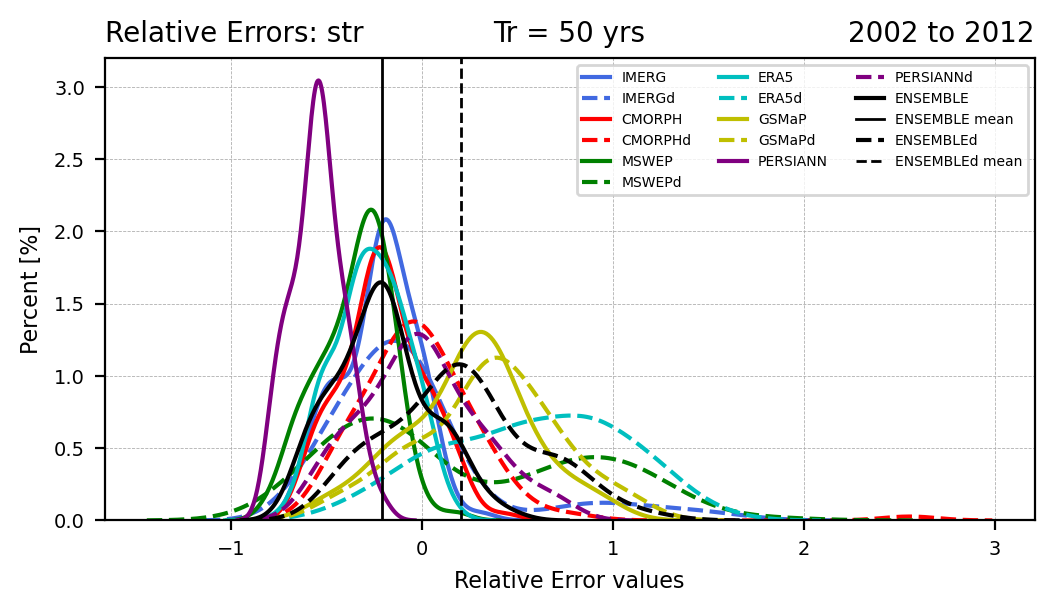

In [29]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_QEs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_QEd,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(CMORPH_QEs,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_QEd,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(MSWEP_QEs,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_QEd,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(ERA5_QEs,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_QEd,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(GSMaP_QEs,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_QEd,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

sns.kdeplot(PERSIANN_QEs,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
sns.kdeplot(PERSIANN_QEd,color=colors[5], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')

sns.kdeplot(ENSEMBLE_QEs,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=1, label='ENSEMBLE mean')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label='ENSEMBLEd mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Relative Errors: {method}', fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_Q80.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


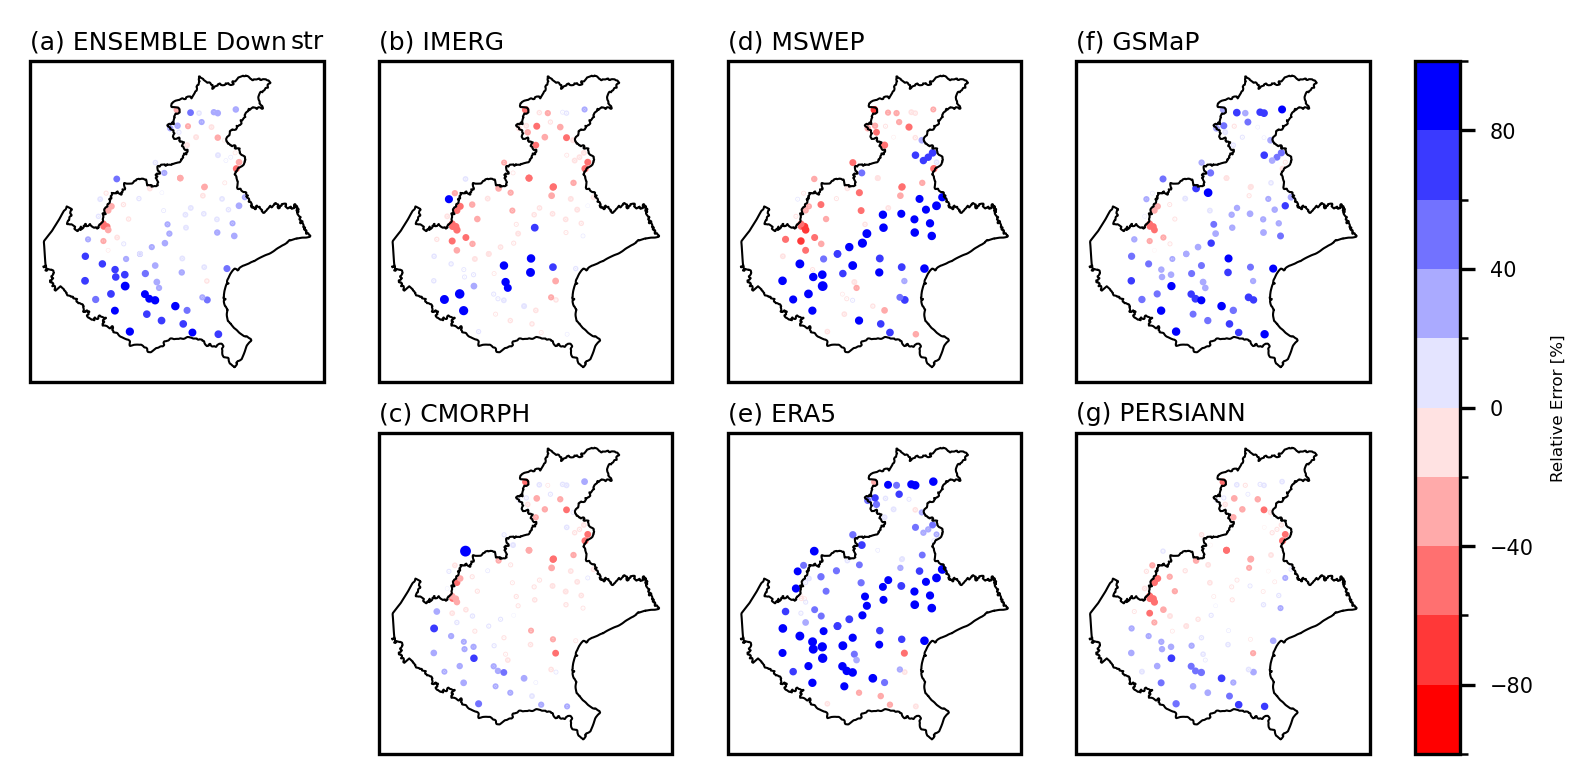

In [30]:
# levels = np.arange(-1.4,1.6,0.2)
# ticks = np.arange(-1.4,1.8,0.4)
levels = np.arange(-100,120,20)
ticks = np.arange(-100,140,40)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
cmap = plt.cm.Spectral_r
cmap = plt.cm.bwr_r

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(2,4)

# =================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(ENSEMBLE_QEd),
                c=ENSEMBLE_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(a) ENSEMBLE Down", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(IMERG_QEd),
                c=IMERG_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(b) IMERG", fontsize=6, loc='left',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(CMORPH_QEd),
                c=CMORPH_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(c) CMORPH", fontsize=6, loc='left',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(MSWEP_QEd),
                c=MSWEP_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(d) MSWEP", fontsize=6, loc='left',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(ERA5_QEd),
                c=ERA5_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(e) ERA5", fontsize=6, loc='left',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(GSMaP_QEd),
                c=GSMaP_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(f) GSMaP", fontsize=6, loc='left',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 3], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(PERSIANN_QEd),
                c=PERSIANN_QEd*100,
                cmap=cmap,
                norm=norm)
ax1.set_title(f"(g) PERSIANN", fontsize=6, loc='left',pad=3)

# =================================================================
cbar_ax = fig.add_axes([0.91, 0.11, 0.025, 0.77])#0.91
cbar = plt.colorbar(a1, cax=cbar_ax, ticks= None, orientation='vertical')
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=5)

# =================================================================
plt.subplots_adjust(wspace=0, hspace=0.16)

Text(1.0, 1.0, 'str')

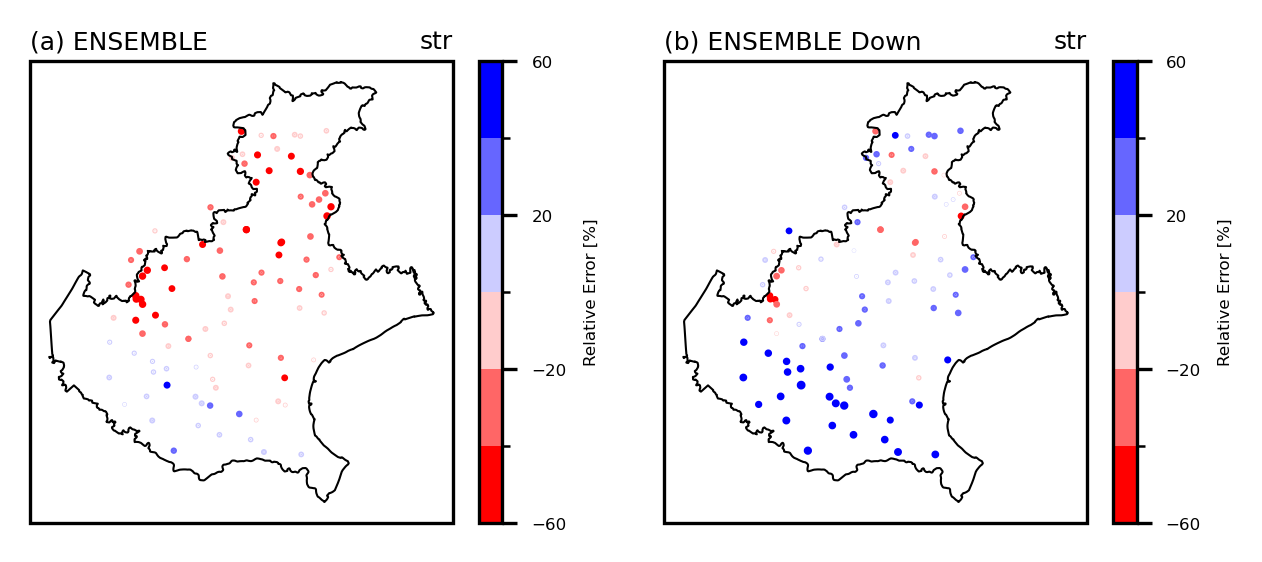

In [31]:
levels = np.arange(-60,80,20)
ticks = np.arange(-60,100,40)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
cmap = plt.cm.Spectral_r
cmap = plt.cm.bwr_r

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# =================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(ENSEMBLE_QEs),
                c=ENSEMBLE_QEs*100,
                norm=norm,
                cmap=cmap)

cbar = plt.colorbar(a1, ticks=ticks, fraction=0.053)
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f"(a) ENSEMBLE", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
a1 = ax1.scatter(
                DF_data['OBS_lon'],
                DF_data['OBS_lat'],
                s=abs(ENSEMBLE_QEd),
                c=ENSEMBLE_QEd*100,
                norm=norm,
                cmap=cmap)

cbar = plt.colorbar(a1, ticks=ticks, fraction=0.053)
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f"(b) ENSEMBLE Down", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

## BIAS Correction

In [32]:
def CDFt(obs, sat):
    """
    Aplica la corrección de sesgo usando CDFt.
    Si se proporciona 'sat_future', también ajusta datos futuros.
    """
    # CDF empírica de los datos observados y satelitales
    obs_sorted = np.sort(obs)
    
    # Transformación de cuantiles
    sat_percentiles = stats.rankdata(sat, method='average') / len(sat)
    corrected_sat = np.interp(sat_percentiles, np.linspace(0,1,len(obs_sorted)), obs_sorted)
    
    return corrected_sat

def ISIMIP_QM(obs, sat):
    """
    Aplica la corrección de sesgo usando ISIMIP QM (Quantile Mapping).
    """
    # Cuantiles de los datos
    quantiles = np.linspace(0, 1, len(obs))
    
    # Ajuste de cuantiles
    obs_quantiles = np.quantile(obs, quantiles)
    sat_quantiles = np.quantile(sat, quantiles)
    
    # Aplicar ajuste a los datos satelitales
    corrected_sat = np.interp(sat, sat_quantiles, obs_quantiles)
    
    return corrected_sat

In [33]:
IMERG_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], IMERG_Mevd.flatten())
IMERG_Q50d_CDFt = IMERG_Q50d_CDFt.reshape(IMERG_Mevd.shape[0],IMERG_Mevd.shape[1])

MSWEP_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], MSWEP_Mevd.flatten())
MSWEP_Q50d_CDFt = MSWEP_Q50d_CDFt.reshape(MSWEP_Mevd.shape[0],MSWEP_Mevd.shape[1])

CMORPH_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], CMORPH_Mevd.flatten())
CMORPH_Q50d_CDFt = CMORPH_Q50d_CDFt.reshape(CMORPH_Mevd.shape[0],CMORPH_Mevd.shape[1])

ERA5_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], ERA5_Mevd.flatten())
ERA5_Q50d_CDFt = ERA5_Q50d_CDFt.reshape(ERA5_Mevd.shape[0],ERA5_Mevd.shape[1])

GSMaP_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], GSMaP_Mevd.flatten())
GSMaP_Q50d_CDFt = GSMaP_Q50d_CDFt.reshape(GSMaP_Mevd.shape[0],GSMaP_Mevd.shape[1])

PERSIANN_Q50d_CDFt = ISIMIP_QM(DF_data['OBS_Q50'], PERSIANN_Mevd.flatten())
PERSIANN_Q50d_CDFt = PERSIANN_Q50d_CDFt.reshape(PERSIANN_Mevd.shape[0],PERSIANN_Mevd.shape[1])


In [34]:
IMERG_CDFt_Qd = []
MSWEP_CDFt_Qd = []
CMORPH_CDFt_Qd = []
ERA5_CDFt_Qd = []
GSMaP_CDFt_Qd = []
PERSIANN_CDFt_Qd = []

for nn in range(len(Q_80)):
    Q_OBS = Q_80['Q50'].values[nn]
    lat_obs = Q_80['Lat'].values[nn]
    lon_obs = Q_80['Lon'].values[nn]

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_CDFt_Qd.append(IMERG_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    MSWEP_CDFt_Qd.append(MSWEP_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    CMORPH_CDFt_Qd.append(CMORPH_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    ERA5_CDFt_Qd.append(ERA5_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    GSMaP_CDFt_Qd.append(GSMaP_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_CDFt_Qd.append(PERSIANN_Q50d_CDFt[min_index[0],min_index[1]])

In [35]:
DF_data['IMERG_CDFt'] = IMERG_CDFt_Qd
DF_data['MSWEP_CDFt'] = MSWEP_CDFt_Qd
DF_data['CMORPH_CDFt'] = CMORPH_CDFt_Qd
DF_data['ERA5_CDFt'] = ERA5_CDFt_Qd
DF_data['GSMaP_CDFt'] = GSMaP_CDFt_Qd
DF_data['PERSIANN_CDFt'] = PERSIANN_CDFt_Qd

ENSEMBLE_CDFt = np.nanmean(
                        [
                        IMERG_CDFt_Qd,
                        MSWEP_CDFt_Qd,
                        CMORPH_CDFt_Qd,
                        ERA5_CDFt_Qd,
                        GSMaP_CDFt_Qd,
                        PERSIANN_CDFt_Qd
                        ])

DF_data['ENSEMBLE_CDFt'] = ENSEMBLE_CDFt

In [36]:
def vector_slope_intercept(OBS,SAT):
    vmin = np.nanmin([OBS.min(), SAT.min()])
    vmax = np.nanmax([OBS.max(), SAT.max()])
    xx = np.arange(vmin,vmax+1,1)
    slope, intercept, _, _, _ = stats.linregress(OBS,SAT)
    y_pred = slope * xx + intercept
    return xx, y_pred

In [37]:
REG_IMERG1 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['IMERG_Q50d'])
REG_IMERG2 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['IMERG_CDFt'])

REG_MSWEP1 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['MSWEP_Q50d'])
REG_MSWEP2 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['MSWEP_CDFt'])

REG_CMORPH1 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['CMORPH_Q50d'])
REG_CMORPH2 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['CMORPH_CDFt'])

REG_ERA51 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['ERA5_Q50d'])
REG_ERA52 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['ERA5_CDFt'])

REG_GSMaP1 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['GSMaP_Q50d'])
REG_GSMaP2 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['GSMaP_CDFt'])

REG_PERSIANN1 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['PERSIANN_Q50d'])
REG_PERSIANN2 = vector_slope_intercept(DF_data['OBS_Q50'], DF_data['PERSIANN_CDFt'])

Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_Scatter_Q80.png


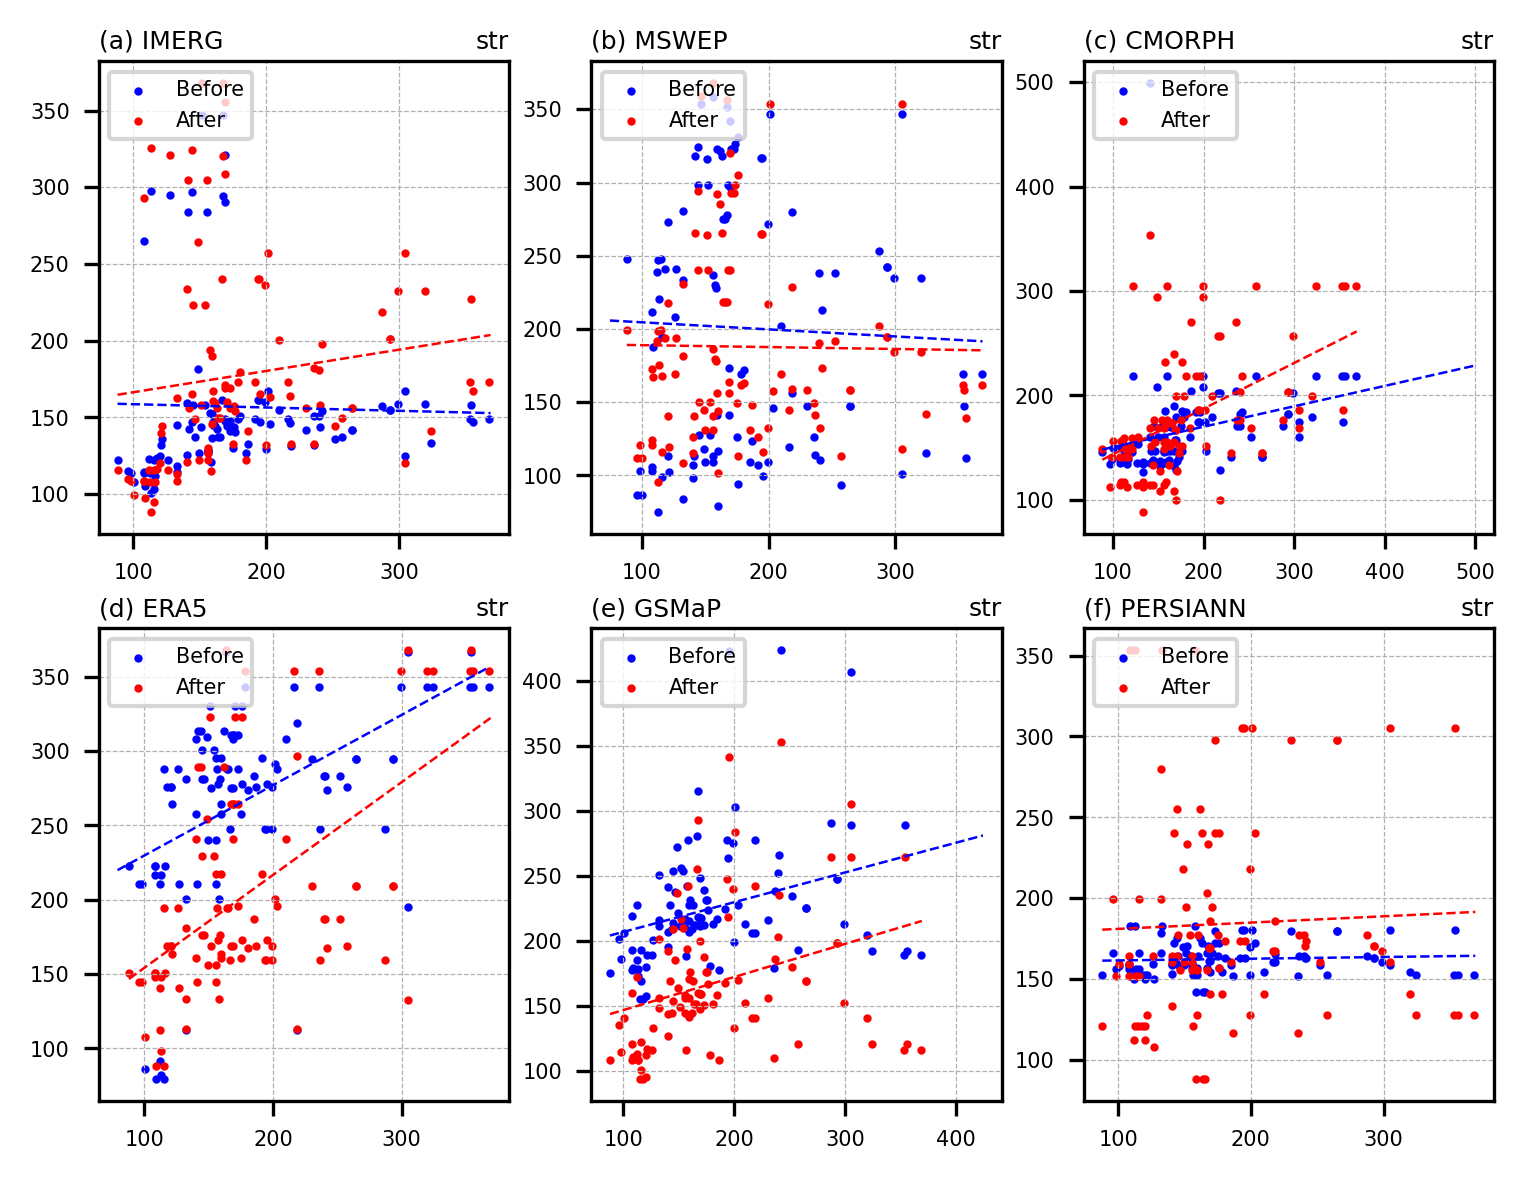

In [38]:
fig = plt.figure(figsize=(6,4.5),dpi=300)
gs = gridspec.GridSpec(2,3)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(DF_data['OBS_Q50'], DF_data['IMERG_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['IMERG_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_IMERG1[0],REG_IMERG1[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_IMERG2[0],REG_IMERG2[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(a) IMERG", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(DF_data['OBS_Q50'], DF_data['MSWEP_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['MSWEP_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_MSWEP1[0],REG_MSWEP1[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_MSWEP2[0],REG_MSWEP2[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(b) MSWEP", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(DF_data['OBS_Q50'], DF_data['CMORPH_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['CMORPH_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_CMORPH1[0],REG_CMORPH1[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_CMORPH2[0],REG_CMORPH2[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(c) CMORPH", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(DF_data['OBS_Q50'], DF_data['ERA5_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['ERA5_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_ERA51[0],REG_ERA51[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_ERA52[0],REG_ERA52[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(d) ERA5", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(DF_data['OBS_Q50'], DF_data['GSMaP_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['GSMaP_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_GSMaP1[0],REG_GSMaP1[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_GSMaP2[0],REG_GSMaP2[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(e) GSMaP", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

# =================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(DF_data['OBS_Q50'], DF_data['PERSIANN_Q50d'],c='b',s=1,label='Before')
ax1.scatter(DF_data['OBS_Q50'], DF_data['PERSIANN_CDFt'],c='r',s=1,label='After')

ax1.plot(REG_PERSIANN1[0],REG_PERSIANN1[1],color='b',linewidth=0.6,linestyle='--')
ax1.plot(REG_PERSIANN2[0],REG_PERSIANN2[1],color='r',linewidth=0.6,linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.legend(fontsize=5,loc=2)
ax1.grid(linewidth=0.3,linestyle='--')

ax1.set_title(f"(f) PERSIANN", fontsize=6, loc='left',pad=3)
ax1.set_title(f"{method}", fontsize=6, loc='right',pad=3)

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_Scatter_Q80.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [39]:
IMERG_CDFt_QEd = (DF_data['IMERG_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
CMORPH_CDFt_QEd = (DF_data['CMORPH_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
MSWEP_CDFt_QEd = (DF_data['MSWEP_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ERA5_CDFt_QEd = (DF_data['ERA5_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
GSMaP_CDFt_QEd = (DF_data['GSMaP_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
PERSIANN_CDFt_QEd = (DF_data['PERSIANN_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ENSEMBLE_CDFt_QEd = (DF_data['ENSEMBLE_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_BiasC_Q80.png


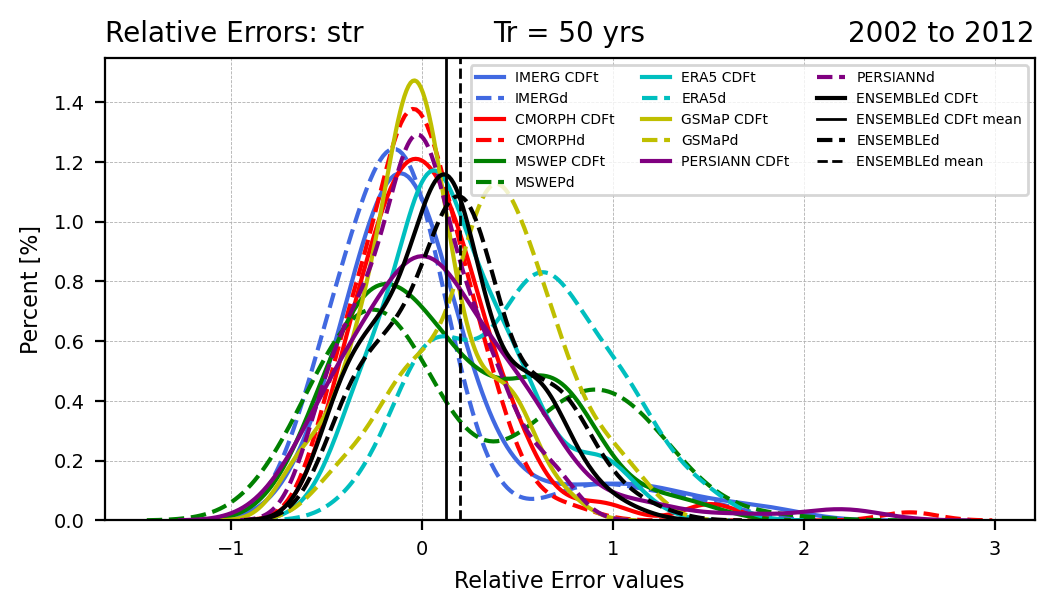

In [40]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_CDFt_QEd,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG CDFt')
sns.kdeplot(IMERG_QEd,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(CMORPH_CDFt_QEd,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH CDFt')
sns.kdeplot(CMORPH_QEd,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(MSWEP_CDFt_QEd,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP CDFt')
sns.kdeplot(MSWEP_QEd,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(ERA5_CDFt_QEd,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5 CDFt')
sns.kdeplot(ERA5_QEd,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(GSMaP_CDFt_QEd,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP CDFt')
sns.kdeplot(GSMaP_QEd,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

sns.kdeplot(PERSIANN_CDFt_QEd,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN CDFt')
sns.kdeplot(PERSIANN_QEd,color=colors[5], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')

sns.kdeplot(ENSEMBLE_CDFt_QEd,color='k', linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd CDFt')
ax1.axvline(np.mean(ENSEMBLE_CDFt_QEd),color='k',linestyle='-',linewidth=1, label='ENSEMBLEd CDFt mean')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label='ENSEMBLEd mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Relative Errors: {method}', fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_BiasC_Q80.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_BiasC2_Q80.png


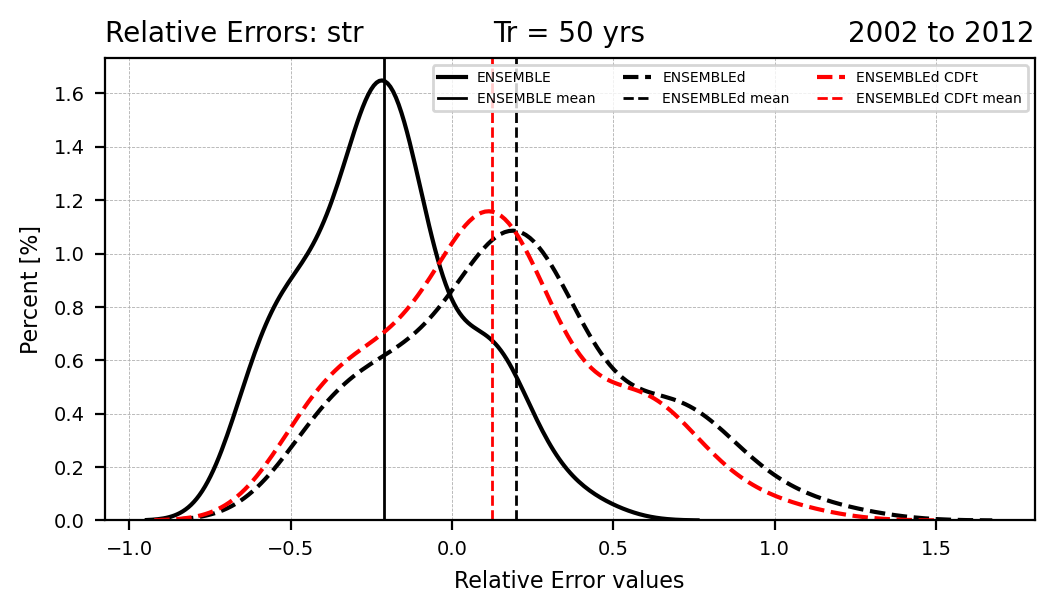

In [41]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(ENSEMBLE_QEs,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=1, label='ENSEMBLE mean')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label='ENSEMBLEd mean')

sns.kdeplot(ENSEMBLE_CDFt_QEd,color='r', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd CDFt')
ax1.axvline(np.mean(ENSEMBLE_CDFt_QEd),color='r',linestyle='--',linewidth=1, label='ENSEMBLEd CDFt mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Relative Errors: {method}', fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_BiasC2_Q80.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


## Use the 20% of the stations

In [42]:
IMERG_Qs, IMERG_Qd = [], []
MSWEP_Qs, MSWEP_Qd = [], []
CMORPH_Qs, CMORPH_Qd = [], []
ERA5_Qs, ERA5_Qd = [], []
GSMaP_Qs, GSMaP_Qd = [], []
PERSIANN_Qs, PERSIANN_Qd = [], []

IMERG_lon_obs, IMERG_lat_obs = [], []
MSWEP_lon_obs, MSWEP_lat_obs = [], []
CMORPH_lon_obs, CMORPH_lat_obs = [], []
ERA5_lon_obs, ERA5_lat_obs = [], []
GSMaP_lon_obs, GSMaP_lat_obs = [], []
PERSIANN_lon_obs, PERSIANN_lat_obs = [], []

for nn in range(len(Q_20)):
    Q_OBS = Q_20['Q50'].values[nn]
    lat_obs = Q_20['Lat'].values[nn]
    lon_obs = Q_20['Lon'].values[nn]

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_lat_ = lat_IMERG[min_index[0]]
    IMERG_lon_ = lon_IMERG[min_index[1]]
    IMERG_Qs.append(IMERG_Mevs[min_index[0],min_index[1]])
    IMERG_Qd.append(IMERG_Mevd[min_index[0],min_index[1]])
    IMERG_lat_obs.append(IMERG_lat_)
    IMERG_lon_obs.append(IMERG_lon_)

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    MSWEP_lat_ = lat_MSWEP[min_index[0]]
    MSWEP_lon_ = lon_MSWEP[min_index[1]]
    MSWEP_Qs.append(MSWEP_Mevs[min_index[0],min_index[1]])
    MSWEP_Qd.append(MSWEP_Mevd[min_index[0],min_index[1]])
    MSWEP_lat_obs.append(MSWEP_lat_)
    MSWEP_lon_obs.append(MSWEP_lon_)

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    CMORPH_lat_ = lat_CMORPH[min_index[0]]
    CMORPH_lon_ = lon_CMORPH[min_index[1]]
    CMORPH_Qs.append(CMORPH_Mevs[min_index[0],min_index[1]])
    CMORPH_Qd.append(CMORPH_Mevd[min_index[0],min_index[1]])
    CMORPH_lat_obs.append(CMORPH_lat_)
    CMORPH_lon_obs.append(CMORPH_lon_)

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    ERA5_lat_ = lat_ERA5[min_index[0]]
    ERA5_lon_ = lon_ERA5[min_index[1]]
    ERA5_Qs.append(ERA5_Mevs[min_index[0],min_index[1]])
    ERA5_Qd.append(ERA5_Mevd[min_index[0],min_index[1]])
    ERA5_lat_obs.append(ERA5_lat_)
    ERA5_lon_obs.append(ERA5_lon_)

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    GSMaP_lat_ = lat_GSMaP[min_index[0]]
    GSMaP_lon_ = lon_GSMaP[min_index[1]]
    GSMaP_Qs.append(GSMaP_Mevs[min_index[0],min_index[1]])
    GSMaP_Qd.append(GSMaP_Mevd[min_index[0],min_index[1]])
    GSMaP_lat_obs.append(GSMaP_lat_)
    GSMaP_lon_obs.append(GSMaP_lon_)

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_lat_ = lat_PERSIANN[min_index[0]]
    PERSIANN_lon_ = lon_PERSIANN[min_index[1]]
    PERSIANN_Qs.append(PERSIANN_Mevs[min_index[0],min_index[1]])
    PERSIANN_Qd.append(PERSIANN_Mevd[min_index[0],min_index[1]])
    PERSIANN_lat_obs.append(PERSIANN_lat_)
    PERSIANN_lon_obs.append(PERSIANN_lon_)

In [43]:
ENSEMBLE_Q50s = np.nanmean(
                        [
                        IMERG_Qs,
                        MSWEP_Qs,
                        CMORPH_Qs,
                        ERA5_Qs,
                        GSMaP_Qs,
                        PERSIANN_Qs
                        ])

ENSEMBLE_Q50d = np.nanmean(
                        [
                        IMERG_Qd,
                        MSWEP_Qd,
                        CMORPH_Qd,
                        ERA5_Qd,
                        GSMaP_Qd,
                        PERSIANN_Qd
                        ])

In [44]:
DF_data = pd.DataFrame({
        'OBS_lat':Q_20['Lat'].values,
        'OBS_lon':Q_20['Lon'].values,
        'OBS_Q50':Q_20['Q50'].values,
        'IMERG_lat':IMERG_lat_obs,
        'IMERG_lon':IMERG_lon_obs,
        'IMERG_Q50s':IMERG_Qs,
        'IMERG_Q50d':IMERG_Qd,
        'MSWEP_lat':MSWEP_lat_obs,
        'MSWEP_lon':MSWEP_lon_obs,
        'MSWEP_Q50s':MSWEP_Qs,
        'MSWEP_Q50d':MSWEP_Qd,
        'CMORPH_lat':CMORPH_lat_obs,
        'CMORPH_lon':CMORPH_lon_obs,
        'CMORPH_Q50s':CMORPH_Qs,
        'CMORPH_Q50d':CMORPH_Qd,
        'ERA5_lat':ERA5_lat_obs,
        'ERA5_lon':ERA5_lon_obs,
        'ERA5_Q50s':ERA5_Qs,
        'ERA5_Q50d':ERA5_Qd,
        'GSMaP_lat':GSMaP_lat_obs,
        'GSMaP_lon':GSMaP_lon_obs,
        'GSMaP_Q50s':GSMaP_Qs,
        'GSMaP_Q50d':GSMaP_Qd,
        'PERSIANN_lat':PERSIANN_lat_obs,
        'PERSIANN_lon':PERSIANN_lon_obs,
        'PERSIANN_Q50s':PERSIANN_Qs,
        'PERSIANN_Q50d':PERSIANN_Qd,
        'ENSEMBLE_Q50s':ENSEMBLE_Q50s,
        'ENSEMBLE_Q50d':ENSEMBLE_Q50d
})

In [45]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

IMERG_QEs = (DF_data['IMERG_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
IMERG_QEd = (DF_data['IMERG_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

CMORPH_QEs = (DF_data['CMORPH_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
CMORPH_QEd = (DF_data['CMORPH_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

MSWEP_QEs = (DF_data['MSWEP_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
MSWEP_QEd = (DF_data['MSWEP_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

ERA5_QEs = (DF_data['ERA5_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ERA5_QEd = (DF_data['ERA5_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

GSMaP_QEs = (DF_data['GSMaP_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
GSMaP_QEd = (DF_data['GSMaP_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

PERSIANN_QEs = (DF_data['PERSIANN_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
PERSIANN_QEd = (DF_data['PERSIANN_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

ENSEMBLE_QEs = (DF_data['ENSEMBLE_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ENSEMBLE_QEd = (DF_data['ENSEMBLE_Q50d']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_Q20.png


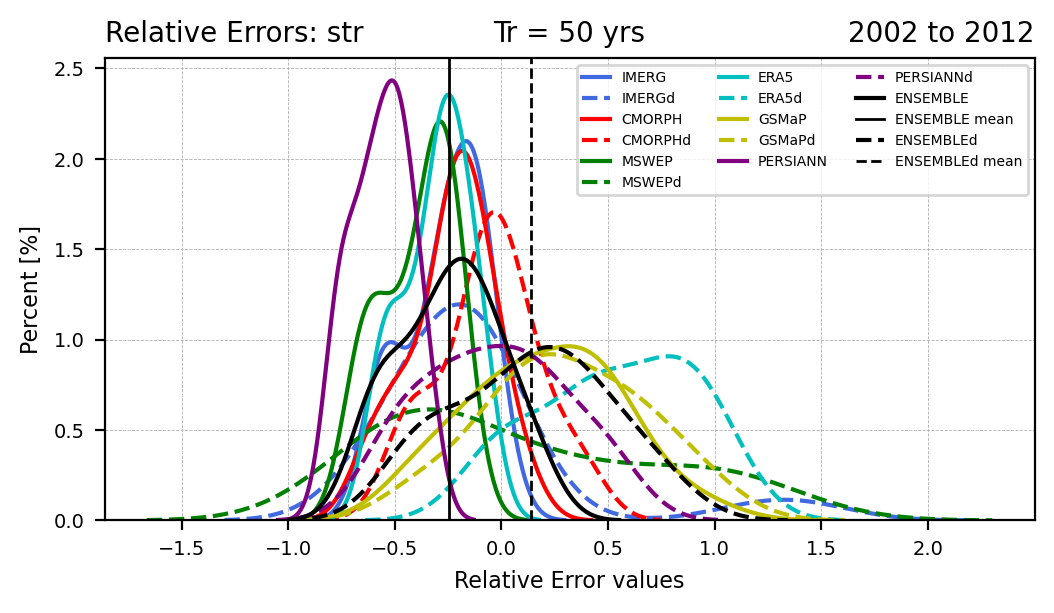

In [46]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_QEs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_QEd,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(CMORPH_QEs,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_QEd,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(MSWEP_QEs,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_QEd,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(ERA5_QEs,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_QEd,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(GSMaP_QEs,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_QEd,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

sns.kdeplot(PERSIANN_QEs,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
sns.kdeplot(PERSIANN_QEd,color=colors[5], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')

sns.kdeplot(ENSEMBLE_QEs,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=1, label='ENSEMBLE mean')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label='ENSEMBLEd mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Relative Errors: {method}', fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_Q20.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)


In [47]:
IMERG_CDFt_Qd = []
MSWEP_CDFt_Qd = []
CMORPH_CDFt_Qd = []
ERA5_CDFt_Qd = []
GSMaP_CDFt_Qd = []
PERSIANN_CDFt_Qd = []

for nn in range(len(Q_20)):
    Q_OBS = Q_20['Q50'].values[nn]
    lat_obs = Q_20['Lat'].values[nn]
    lon_obs = Q_20['Lon'].values[nn]

    # =======================================================================
    # IMERG
    distances = ART_pre.haversine(lat2d_IMERG, lon2d_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_CDFt_Qd.append(IMERG_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # MSWEP
    distances = ART_pre.haversine(lat2d_MSWEP, lon2d_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    MSWEP_CDFt_Qd.append(MSWEP_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # CMORPH
    distances = ART_pre.haversine(lat2d_CMORPH, lon2d_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    CMORPH_CDFt_Qd.append(CMORPH_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # ERA5
    distances = ART_pre.haversine(lat2d_ERA5, lon2d_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    ERA5_CDFt_Qd.append(ERA5_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # GSMaP
    distances = ART_pre.haversine(lat2d_GSMaP, lon2d_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)  
    GSMaP_CDFt_Qd.append(GSMaP_Q50d_CDFt[min_index[0],min_index[1]])

    # =======================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat2d_PERSIANN, lon2d_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_CDFt_Qd.append(PERSIANN_Q50d_CDFt[min_index[0],min_index[1]])

In [48]:
DF_data['IMERG_CDFt'] = IMERG_CDFt_Qd
DF_data['MSWEP_CDFt'] = MSWEP_CDFt_Qd
DF_data['CMORPH_CDFt'] = CMORPH_CDFt_Qd
DF_data['ERA5_CDFt'] = ERA5_CDFt_Qd
DF_data['GSMaP_CDFt'] = GSMaP_CDFt_Qd
DF_data['PERSIANN_CDFt'] = PERSIANN_CDFt_Qd

ENSEMBLE_CDFt = np.nanmean(
                        [
                        IMERG_CDFt_Qd,
                        MSWEP_CDFt_Qd,
                        CMORPH_CDFt_Qd,
                        ERA5_CDFt_Qd,
                        GSMaP_CDFt_Qd,
                        PERSIANN_CDFt_Qd
                        ])

DF_data['ENSEMBLE_CDFt'] = ENSEMBLE_CDFt

In [49]:
IMERG_CDFt_QEd = (DF_data['IMERG_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
CMORPH_CDFt_QEd = (DF_data['CMORPH_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
MSWEP_CDFt_QEd = (DF_data['MSWEP_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ERA5_CDFt_QEd = (DF_data['ERA5_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
GSMaP_CDFt_QEd = (DF_data['GSMaP_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
PERSIANN_CDFt_QEd = (DF_data['PERSIANN_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
ENSEMBLE_CDFt_QEd = (DF_data['ENSEMBLE_CDFt']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

Export figure to: ../figures/QERROR/Relative_Error_str_2002_2012_BiasC2_Q20.png


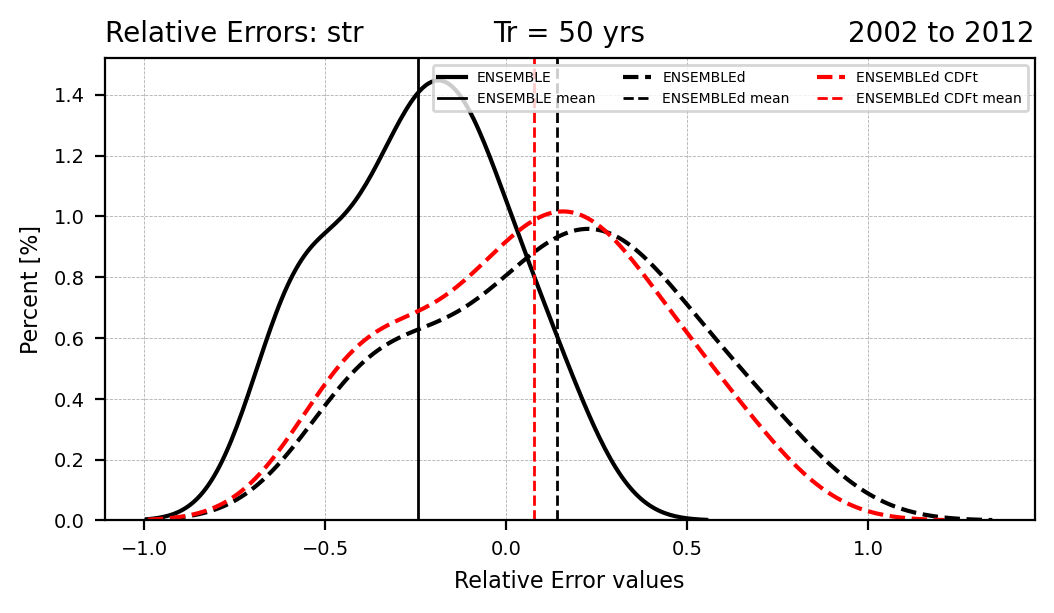

In [50]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(ENSEMBLE_QEs,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(ENSEMBLE_QEs),color='k',linestyle='-',linewidth=1, label='ENSEMBLE mean')

sns.kdeplot(ENSEMBLE_QEd,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(ENSEMBLE_QEd),color='k',linestyle='--',linewidth=1, label='ENSEMBLEd mean')

sns.kdeplot(ENSEMBLE_CDFt_QEd,color='r', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd CDFt')
ax1.axvline(np.mean(ENSEMBLE_CDFt_QEd),color='r',linestyle='--',linewidth=1, label='ENSEMBLEd CDFt mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'Relative Errors: {method}', fontsize=10, loc='left')
ax1.set_title(f'Tr = 50 yrs',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

salida = os.path.join('..','figures','QERROR',f'Relative_Error_{method}_{yy_s}_{yy_e}_BiasC2_Q20.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)
